In [1]:
from sklearn.model_selection import train_test_split
from  sklearn.model_selection import GridSearchCV
from sklearn import metrics,ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [5]:
# Load training data
df_train = pd.read_csv('D:/secondterm/6010S/project/train.csv')
df_test = pd.read_csv('D:/secondterm/6010S/project/test.csv')
# 2% sample of items
df_train = df_train.sample(frac=0.1)


In [6]:
# Load and merge songs data
songs = pd.read_csv('D:/secondterm/6010S/project/songs.csv')
df_train = pd.merge(df_train, songs, on='song_id', how='left')
df_test = pd.merge(df_test, songs, on='song_id', how='left')
del songs

# Load and merge songs data
members = pd.read_csv('D:/secondterm/6010S/project/members.csv')
df_train = pd.merge(df_train, members, on='msno', how='left')
df_test = pd.merge(df_test, members, on='msno', how='left')
del members

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737742 entries, 0 to 737741
Data columns (total 18 columns):
msno                      737742 non-null object
song_id                   737742 non-null object
source_system_tab         735318 non-null object
source_screen_name        696274 non-null object
source_type               735595 non-null object
target                    737742 non-null int64
song_length               737734 non-null float64
genre_ids                 726015 non-null object
artist_name               737734 non-null object
composer                  570277 non-null object
lyricist                  419873 non-null object
language                  737732 non-null float64
city                      737742 non-null int64
bd                        737742 non-null int64
gender                    440520 non-null object
registered_via            737742 non-null int64
registration_init_time    737742 non-null int64
expiration_date           737742 non-null int64
dtypes: flo

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 18 columns):
id                        int64
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
expiration_date           int64
dtypes: float64(2), int64(6), object(10)
memory usage: 370.6+ MB


In [9]:
# Replace train NA
for i in df_train.select_dtypes(include=['object']).columns:
    df_train[i][df_train[i].isnull()] = 'unknown'
df_train = df_train.fillna(value=0)

In [10]:
# Replace test NA
for i in df_test.select_dtypes(include=['object']).columns:
    df_test[i][df_test[i].isnull()] = 'unknown'
df_test = df_test.fillna(value=0)

In [11]:
# Create train Dates
# registration_init_time
df_train.registration_init_time = pd.to_datetime(df_train.registration_init_time, format='%Y%m%d', errors='ignore')
df_train['registration_init_time_year'] = df_train['registration_init_time'].dt.year
df_train['registration_init_time_month'] = df_train['registration_init_time'].dt.month
df_train['registration_init_time_day'] = df_train['registration_init_time'].dt.day

# expiration_date
df_train.expiration_date = pd.to_datetime(df_train.expiration_date,  format='%Y%m%d', errors='ignore')
df_train['expiration_date_year'] = df_train['expiration_date'].dt.year
df_train['expiration_date_month'] = df_train['expiration_date'].dt.month
df_train['expiration_date_day'] = df_train['expiration_date'].dt.day

In [12]:
# Create test Dates
# registration_init_time
df_test.registration_init_time = pd.to_datetime(df_test.registration_init_time, format='%Y%m%d', errors='ignore')
df_test['registration_init_time_year'] = df_test['registration_init_time'].dt.year
df_test['registration_init_time_month'] = df_test['registration_init_time'].dt.month
df_test['registration_init_time_day'] = df_test['registration_init_time'].dt.day

# expiration_date
df_test.expiration_date = pd.to_datetime(df_test.expiration_date,  format='%Y%m%d', errors='ignore')
df_test['expiration_date_year'] = df_test['expiration_date'].dt.year
df_test['expiration_date_month'] = df_test['expiration_date'].dt.month
df_test['expiration_date_day'] = df_test['expiration_date'].dt.day

In [13]:
# Dates to category
df_train['registration_init_time'] = df_train['registration_init_time'].astype('category')
df_train['expiration_date'] = df_train['expiration_date'].astype('category')

df_test['registration_init_time'] = df_test['registration_init_time'].astype('category')
df_test['expiration_date'] = df_test['expiration_date'].astype('category')



In [14]:
# Object data to category
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].astype('category')
    
# Encoding categorical features
for col in df_train.select_dtypes(include=['category']).columns:
    df_train[col] = df_train[col].cat.codes

# Object data to category
for col in df_test.select_dtypes(include=['object']).columns:
    df_test[col] = df_test[col].astype('category')
    
# Encoding categorical features
for col in df_test.select_dtypes(include=['category']).columns:
    df_test[col] = df_test[col].cat.codes

In [15]:
df_train.corr()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
msno,1.000000,-0.000043,0.009032,-0.006679,-0.001381,0.001333,0.000663,0.002781,0.004545,0.003983,...,-0.006279,-0.002206,0.005462,0.012354,0.004707,0.011535,0.012066,0.004716,0.007829,0.001443
song_id,-0.000043,1.000000,-0.004313,0.001556,0.005722,-0.001632,-0.011800,0.008196,-0.018867,-0.034168,...,0.000924,-0.002586,0.001159,-0.000298,0.001418,-0.000991,-0.000129,-0.000875,0.000710,-0.000463
source_system_tab,0.009032,-0.004313,1.000000,-0.055913,-0.079261,0.032624,0.024693,0.032692,0.037159,0.055397,...,-0.027032,0.034255,-0.042776,0.056543,-0.039004,-0.015130,0.007653,0.039074,0.011409,0.007863
source_screen_name,-0.006679,0.001556,-0.055913,1.000000,0.400734,-0.049168,0.024264,-0.021426,0.010783,0.019956,...,0.014040,-0.030190,0.036541,-0.032271,0.035197,0.004777,-0.002996,-0.021693,-0.008021,-0.001968
source_type,-0.001381,0.005722,-0.079261,0.400734,1.000000,-0.125326,0.015297,-0.052220,-0.020606,-0.001627,...,0.023286,-0.025249,0.032947,-0.044121,0.031032,0.006240,0.000832,-0.037417,0.001374,-0.004982
target,0.001333,-0.001632,0.032624,-0.049168,-0.125326,1.000000,-0.001659,0.019923,0.013265,0.000340,...,-0.014855,0.008096,-0.002540,0.060448,-0.001532,-0.006796,-0.003196,0.044094,0.009954,0.002884
song_length,0.000663,-0.011800,0.024693,0.024264,0.015297,-0.001659,1.000000,0.029894,0.117002,0.100361,...,0.004738,0.002951,-0.005818,0.006172,-0.006072,0.002518,0.000827,0.004358,0.001829,-0.000235
genre_ids,0.002781,0.008196,0.032692,-0.021426,-0.052220,0.019923,0.029894,1.000000,0.198564,0.146256,...,-0.005250,0.004633,-0.002676,0.004728,-0.003370,0.002946,0.001855,0.005871,-0.004708,0.001135
artist_name,0.004545,-0.018867,0.037159,0.010783,-0.020606,0.013265,0.117002,0.198564,1.000000,0.339331,...,-0.003721,0.001046,-0.008005,0.011827,-0.008565,0.004687,-0.000111,0.007851,0.002176,0.003654
composer,0.003983,-0.034168,0.055397,0.019956,-0.001627,0.000340,0.100361,0.146256,0.339331,1.000000,...,-0.004276,0.001241,-0.004514,0.008276,-0.005019,0.004601,0.001261,0.005387,0.002406,0.000806


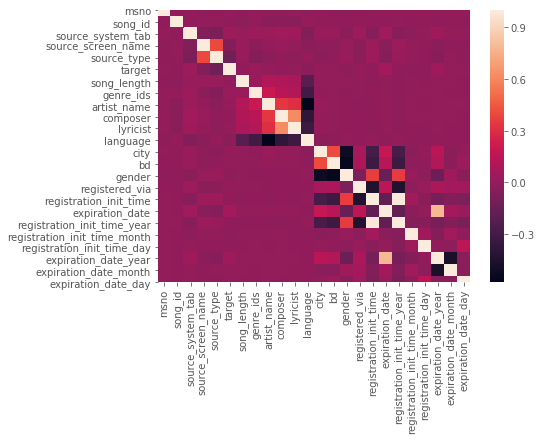

In [17]:
# Correlation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df_train.corr())
plt.show()

In [18]:
# Model with the best estimator
model1 = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model1.fit(df_train[df_train.columns[df_train.columns != 'target']], df_train.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [19]:
df_train_plot = pd.DataFrame({'features': df_train.columns[df_train.columns != 'target'],
                        'importances': model1.feature_importances_})
df_train_plot = df_train_plot.sort_values('importances', ascending=False)

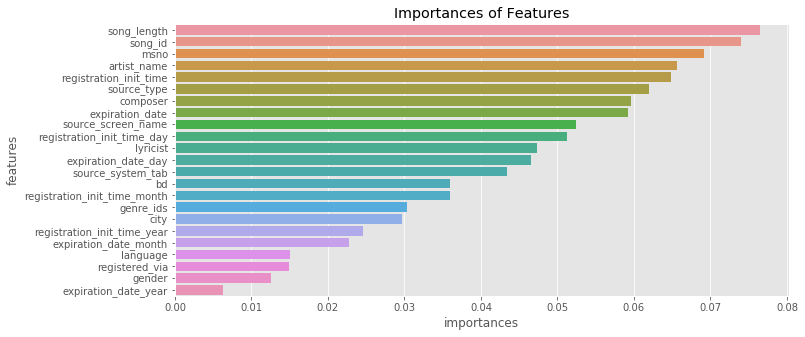

In [20]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_train_plot.importances, y = df_train_plot.features)
plt.title('Importances of Features')
plt.show()

In [21]:
model1.feature_importances_

array([0.06922275, 0.07398746, 0.04336824, 0.05247993, 0.06198551,
       0.07642222, 0.03037271, 0.06567333, 0.0595825 , 0.04726938,
       0.01502925, 0.02963842, 0.03599406, 0.01258356, 0.01490191,
       0.06485574, 0.05924873, 0.0245668 , 0.0359445 , 0.05122967,
       0.00629342, 0.02281516, 0.04653476])

In [22]:
# Drop columns with importances < 0.025
df_train = df_train.drop(df_train_plot.features[df_train_plot.importances < 0.025].tolist(), 1)
# Selected columns
list(df_train.columns)

['msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'target',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'city',
 'bd',
 'registration_init_time',
 'expiration_date',
 'registration_init_time_month',
 'registration_init_time_day',
 'expiration_date_day']

In [26]:
# Drop columns
df_test = df_test.drop(['gender','registered_via', 'language','registration_init_time_year','expiration_date_year','expiration_date_month'], 1)list(df_test.columns)

['id',
 'msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'city',
 'bd',
 'registration_init_time',
 'expiration_date',
 'registration_init_time_month',
 'registration_init_time_day',
 'expiration_date_day']

In [27]:
target = df_train.pop('target')

In [28]:
train_data=df_train
train_labels=target

test_data=df_test.drop(['id'], 1)

In [29]:
#XGboost
xgmodel = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)
xgmodel.fit(train_data, train_labels)
xgpredict_labels = xgmodel.predict(test_data)

In [30]:
list(xgpredict_labels)

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [31]:
# Read the sample_submission CSV
submission = pd.read_csv( 'D:/secondterm/6010S/project/sample_submission.csv')
# Set the target to our predictions
submission.target=xgpredict_labels
# Save the submission file
submission.to_csv('D:/secondterm/6010S/project/submissionnew.csv',index=False)

In [32]:
submission

,id,target
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2556785,2556785,0
2556786,2556786,0
2556787,2556787,0
2556788,2556788,0


In [33]:
from catboost import CatBoostClassifier

In [34]:
model2 = CatBoostClassifier(learning_rate=0.1, max_depth=10,iterations=500)
model2.fit(train_data, train_labels)

0:	learn: 0.6852820	total: 294ms	remaining: 2m 26s
1:	learn: 0.6788024	total: 530ms	remaining: 2m 11s
2:	learn: 0.6737014	total: 764ms	remaining: 2m 6s
3:	learn: 0.6694797	total: 1s	remaining: 2m 4s
4:	learn: 0.6658718	total: 1.25s	remaining: 2m 3s
5:	learn: 0.6628912	total: 1.49s	remaining: 2m 2s
6:	learn: 0.6606802	total: 1.72s	remaining: 2m 1s
7:	learn: 0.6584226	total: 1.95s	remaining: 1m 59s
8:	learn: 0.6566744	total: 2.17s	remaining: 1m 58s
9:	learn: 0.6554189	total: 2.41s	remaining: 1m 57s
10:	learn: 0.6540694	total: 2.64s	remaining: 1m 57s
11:	learn: 0.6528999	total: 2.88s	remaining: 1m 57s
12:	learn: 0.6519818	total: 3.13s	remaining: 1m 57s
13:	learn: 0.6511230	total: 3.39s	remaining: 1m 57s
14:	learn: 0.6504263	total: 3.66s	remaining: 1m 58s
15:	learn: 0.6495820	total: 3.94s	remaining: 1m 59s
16:	learn: 0.6490230	total: 4.2s	remaining: 1m 59s
17:	learn: 0.6486118	total: 4.44s	remaining: 1m 58s
18:	learn: 0.6481570	total: 4.68s	remaining: 1m 58s
19:	learn: 0.6477285	total: 4.9

In [35]:
catpredict_labels = model2.predict(test_data)

In [36]:
# Read the sample_submission CSV
submission2 = pd.read_csv( 'D:/secondterm/6010S/project/sample_submission.csv')
# Set the target to our predictions
submission2.target=catpredict_labels
# Save the submission file
submission2.to_csv('D:/secondterm/6010S/project/submissionnew2.csv',index=False)

In [37]:
submission2

,id,target
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2556785,2556785,0
2556786,2556786,0
2556787,2556787,0
2556788,2556788,0
